In [5]:
# (base) nana ~ % conda activate tensorflow
!python --version

Python 3.8.10


In [4]:
%pylab inline
from tensorflow.keras import layers # 1.14.0
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from glob import glob  # directory paths
import pandas as pd    # big data management 
from sklearn.cluster import KMeans  # ML package, clustering code, similarity measure
import numpy as np # 1.16.4
from tensorflow.keras import layers # 1.14.0
from numpy import array, zeros, prod
import seaborn as sns
import matplotlib

Populating the interactive namespace from numpy and matplotlib


# Data Processing

In [4]:
# loads all the touch files into numpy format
dirs = glob('Experiment/*/') 

length = 250  # length of data file (10 seconds at 25 samples per second)
total_type = []  # sentence in survey corresponding to the touch data 
total_touch = []  # all touch data here
type_num = 33  # number of questions in survey

for path in dirs:
    files_path = glob(path + '*') # num_paths -> files_path
    for num_path in files_path:
        numstr = num_path.split('.')[-1]#Split the num_path from files_path until '.' from the end of the num_path
        if numstr.isdigit():
            num = int(numstr) 
                        
        temp_data = []
        with open(num_path, 'r') as f:  
            for _, line in enumerate(f):
                temp_data.append(line.split()[0].split(','))   # comma separated data
#                 print("temp_data:", temp_data) #['0', '169', '0', '86', '0', '0'],
#                 print(temp_data[-1])
        # if number of rows is less than length=250 repeat the last row to get 250 row in total
        while len(temp_data) < length:
            last_data = temp_data[-1]
#             print(last_data) # ['0', '323', '0', '0', '0', '0'] \\ ['0', '367', '0', '0', '0', '0']
            temp_data.append(last_data)
#         print("len(temp_data):", len(temp_data))
        for i in range(len(temp_data)-length): #len(temp_data)= 1672   1175   
            total_touch.append(temp_data[i:i+250])
            total_type.append(num) # 1, 2
#             print("total_type:", total_type)
            
#         print(total_type)
#         print(array(total_touch).shape, num_path) # which files cause error in shape & convert it from 3d to 2d

total_touch = np.array(total_touch)
print("total_touch.shape:", total_touch.shape) 
# print("num is:", total_type)
total_length = len(total_touch) 
# print("total_length:", total_length) 


('total_touch.shape:', (119337, 250, 6))


In [5]:
liwc_csv = pd.read_csv('liwc.csv')  # reading in the LIWC scores for all lyrics
liwc_csv[0:3]

,A,B,C,WC,Analytic,Clout,Authentic,Tone,posemo,negemo,anx,anger,sad,female,male,tentat,certain,sexual,swear
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \nAnd...",32,11.24,73.40,7.84,99.00,12.50,0.0,0.0,0.0,0.0,9.38,3.12,6.25,0.00,0.0,0.0
1,ABBA,Ahe's My Kind Of Girl,"She's just my kind of girl, she makes me feel ...",42,1.00,31.71,2.82,70.57,2.38,0.0,0.0,0.0,0.0,19.05,0.00,7.14,4.76,0.0,0.0
2,ABBA,Ahe's My Kind Of Girl,And when we go for a walk in the park \nAnd s...,33,39.45,96.52,85.21,25.77,0.00,0.0,0.0,0.0,0.0,3.03,0.00,0.00,3.03,0.0,0.0


In [6]:
# liwc_csv.shape
# # liwc_csv.size
# len(liwc_csv)
# liwc_csv.iloc[0][8:]

In [7]:
%%time
from __future__ import print_function 
csv_len = len(liwc_csv) # 310543
feature_num = len(liwc_csv.iloc[0][8:].values) # = 11 Identifies the number of features - 0:8 is meta-data
total_features = zeros((type_num, feature_num))
features = []

for i in range(csv_len):  # range over lyrics
    if i % 1000 == 0:
        print("i % 1000 == 0:", i / csv_len, end="\r")
    features.append(liwc_csv.iloc[i, 8:].values)  # associate feature 1 with its score in lyric 1
features = array(features)

# sentences in the experiment
text = ['Something that you said burnin\' in my head',
        'Y\'all want a single say fuck that  \nFuck that, fuck that  \nFuck that',
        'Naked - naked - just get back to basics  \nNaked - face it - you can\'t fake it when youre  \n',
        'All wound up  \nOn the edge',
        'I\'ve never felt good  \nI\'ve never felt bad',
        'Shell shock battle fatigue',
        'Good morning beautiful, a beautiful day',
        'The Humpty Dance is your chance to do the Hump',
        'Tears of rage, tears of pain',
        'Welcome to the pleasuredome',
        'But maybe I\'m crazy',
        'Still I\'m sad  \n',
        'Promise me love, promise me  \nKisses sweet love',
        'Cry baby cry  \nMake your mother sigh  \nShe\'s old enough to know better.  \nSo cry baby cry',
        'Lover, lover, lover  \n',
        'Never give up  \nNever hold you head down',
        'She\'s losing,',
        'Bitch,  \nStupid ass bitch',
        'If I, if I, if I, if I, if I, if I, if I, if I',
        'Damn  \nDamn girl',
        'Kill tonight, kill tonight  \n',
        'But try to find  \n',
        'Tell me why do my tears fall like rain\?  \nWorry worry worry',
        'I\'m drowning  \nAnger my bitter breath',
        'Sorry \(I\'m sorry\)',
        'Wake up in the morning, my hands cold in fear.',
        'All together now  \n\(All together now\)  \n',
        'Her feelings she hides  \n',
        'Boys boys boys  \nWe like boys in cars  \nBoys boys boys  \n',
        'He\'s a woman, she\'s a man  \n',
        'Mother\'s pride  \nBaby boy',
        'Strong girl, she\'s like an ocean',
        'He drank Coca-Cola, he was eating Wonder Bread',
        ]

for i, txt in enumerate(text):  # retrieve feature score for all 33 lyrics
    print(i, end='\r')
    total_features[i] = liwc_csv[liwc_csv['C'].str.contains(txt)].iloc[0, 8:].values

CPU times: user 1min 23s, sys: 1.51 s, total: 1min 24s
Wall time: 1min 23s


In [8]:
total_features.shape, total_touch.shape

((33, 11), (119337, 250, 6))

# Flatten dataset from 3D to 2D

In [9]:
# Flatten data based on columns which represnet the number of sensors
total_touch_np_array = np.array(total_touch).astype(np.float)
total_touch_np_array_flatten = total_touch_np_array.flatten().reshape(total_touch_np_array.shape[0]*total_touch_np_array.shape[1], total_touch_np_array.shape[2])
total_touch_np_array_flatten.shape

(29834250, 6)

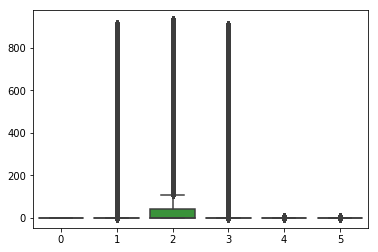

In [9]:
# Boxplot to visualize every sensor of data
all_arr = [total_touch_np_array_flatten[:,0],
           total_touch_np_array_flatten[:,1],
           total_touch_np_array_flatten[:,2],
           total_touch_np_array_flatten[:,3],
           total_touch_np_array_flatten[:,4],
           total_touch_np_array_flatten[:,5]]
sns.boxplot(data=all_arr) #, showfliers=False

In [10]:
print("First Sensor:", max(total_touch_np_array_flatten[:,0]), min(total_touch_np_array_flatten[:,0]))
print("Second Sensor:", max(total_touch_np_array_flatten[:,1]), min(total_touch_np_array_flatten[:,1]))
print("Third Sensor:", max(total_touch_np_array_flatten[:,2])), min(total_touch_np_array_flatten[:,2])
print("Fourth Sensor:", max(total_touch_np_array_flatten[:,3]), min(total_touch_np_array_flatten[:,3]))
print("Fifth Sensor:", max(total_touch_np_array_flatten[:,4]), min(total_touch_np_array_flatten[:,4]))
print("Sixth Sensor:", max(total_touch_np_array_flatten[:,5]), min(total_touch_np_array_flatten[:,5]))
 

First Sensor: 0.0 0.0
Second Sensor: 914.0 0.0
Third Sensor: 930.0
Fourth Sensor: 909.0 0.0
Fifth Sensor: 5.0 0.0
Sixth Sensor: 4.0 0.0


In [11]:
first_sensor = total_touch_np_array_flatten[:,0]
count = 0
for i, item in enumerate(first_sensor):
    if item == 0.0:
        count += 1
print("All values:", len(first_sensor),", zero values:", count, ", Non-zero values:", len(first_sensor) - count, 
     ", Max is:", max(total_touch_np_array_flatten[:,0]),", Min is:", min(total_touch_np_array_flatten[:,0]))
    

All values: 29834250 , zero values: 29834250 , Non-zero values: 0 , Max is: 0.0 , Min is: 0.0


#### Calculate Boxplot Quartiles' values for the third sensor which its max value is 930

Q3:: 0    0.047312
Name: 0.75, dtype: float64 Q1:: 0    0.0
Name: 0.25, dtype: float64
upper_extreme: 0    0.11828
dtype: float64 lower_extreme: 0   -0.070968
dtype: float64


0.11701716205517598

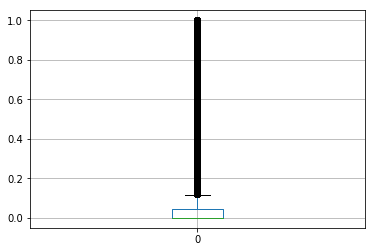

In [12]:
# from sklearn.preprocessing import scale, normalize, minmax_scale

# scale_C = scale(total_touch_np_array_flatten[:, 3])
# df = pd.DataFrame(scale_C)
# df.hist(bins=10)

from sklearn.preprocessing import scale, normalize, minmax_scale

scale_C = minmax_scale(total_touch_np_array_flatten[:, 2], feature_range=(0, 1)) # 2 is third sensor values
df = pd.DataFrame(scale_C) 
# df.hist(bins=10)
df.boxplot()

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

print("Q3::", Q3, "Q1::", Q1)
IQR = Q3 - Q1
upper_extreme = Q3 + (1.5 * IQR)
lower_extreme = Q1 - (1.5 * IQR)
print("upper_extreme:",upper_extreme, "lower_extreme:", lower_extreme)
np.std(scale_C)


### Show STD and Mean value for Hand Collected Data

In [28]:
std_hand_collected_data = numpy.std(np.array(total_touch_np_array_flatten).astype(np.float), axis=0)
# print("STD:", numpy.around(std_hand_collected_data, 0))
print("STD:", std_hand_collected_data)

mean_hand_collected_data = numpy.mean(np.array(total_touch_np_array_flatten).astype(np.float), axis=0)
# print('Mean:', numpy.around(mean_hand_collected_data, 1))
print('Mean:', mean_hand_collected_data)

STD: [0.00000000e+00 1.41081084e+02 1.08825961e+02 1.56057032e+02
 8.88589769e-02 6.34651632e-02]
Mean: [0.00000000e+00 5.28352990e+01 4.80910426e+01 6.04080032e+01
 3.96577759e-03 2.42057367e-03]


In [14]:
# a = np.array([[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]])
# a.shape
# numpy.std(a, axis=0)
# numpy.std(total_touch, axis=0)
std_hand_collected_data = numpy.std(np.array(total_touch_np_array_flatten).astype(np.float), axis=0)
print("STD:", numpy.around(std_hand_collected_data, 3))
mean_hand_collected_data = numpy.mean(np.array(total_touch_np_array_flatten).astype(np.float), axis=0)
print('Mean:', numpy.around(mean_hand_collected_data, 3))

STD: [0.00000e+00 1.41081e+02 1.08826e+02 1.56057e+02 8.90000e-02 6.30000e-02]
Mean: [0.0000e+00 5.2835e+01 4.8091e+01 6.0408e+01 4.0000e-03 2.0000e-03]


In [15]:
# df['A'].hist(bins=10)
2.0000e-03

0.002

In [ ]:
# all_arr_1 = all_arr[0:2000]

# A = all_arr_1[0][0:2000]
# B = all_arr_1[1][0:2000]
# C = all_arr_1[2][0:2000]
# D = all_arr_1[3][0:2000]
# E = all_arr_1[4][0:2000]
# F = all_arr_1[5][0:2000]
# df = pd.DataFrame(all_arr_1, columns = ['A','B','C', 'D','E','F'])
# df['F'].hist(bins=10) 



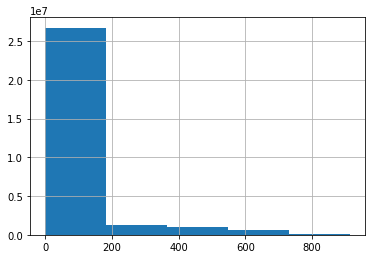

In [117]:
df['B'].hist(bins=10)

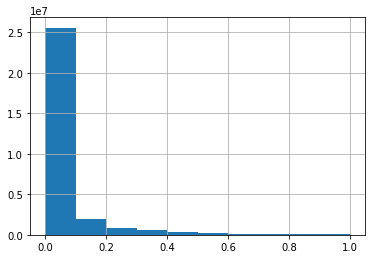

In [118]:
df['C'].hist(bins=10)

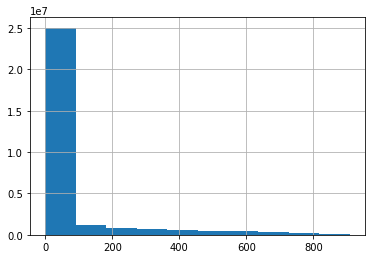

In [119]:
df['D'].hist(bins=10)

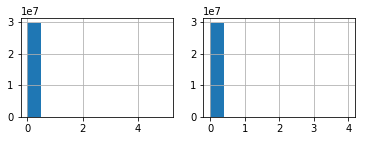

In [175]:
plt.subplot(2, 2, 1)
df['E'].hist(bins=10)

plt.subplot(2, 2, 2)
df['F'].hist(bins=10)


In [ ]:
# This cause the kernel to die!
# A = all_arr[0][0:2000]
# B = all_arr[1][0:2000]
# C = all_arr[2][0:2000]
# D = all_arr[3][0:2000]
# E = all_arr[4][0:2000]
# F = all_arr[5][0:2000]
# df = pd.DataFrame(all_arr, columns = ['A','B','C', 'D','E','F'])
# df.head() 

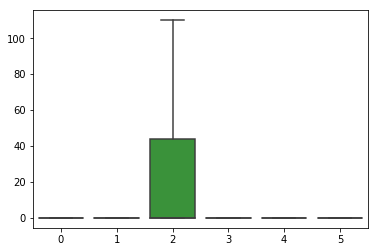

In [11]:
# # Nana
# total_features[1]  # affect feature vector associated with lyric 0  
# liwc_csv[liwc_csv['C'].str.contains(txt)]
# liwc_csv[liwc_csv['C'].str.contains(txt)].iloc[0, 8:]


all_arr = [total_touch_np_array_flatten[:,0],
           total_touch_np_array_flatten[:,1],
           total_touch_np_array_flatten[:,2],
           total_touch_np_array_flatten[:,3],
           total_touch_np_array_flatten[:,4],
           total_touch_np_array_flatten[:,5]]
sns.boxplot( data=all_arr, showfliers=False)

In [9]:
def punching_data():  # generates many 10 second samples of synthetic punching data
    total_time = 250 # nana 250
    x = zeros((total_time, 6))  # 250 X 6 template
    random_list = [0, 2, 3, 4, 5]
    light = [0, 3, 4, 5]#random.sample(random_list, 3)
    heavy = [2]#[x for x in random_list if x not in light]

    start = np.random.randint(20, 25)
    interval = np.random.randint(20, 25)
    times = np.random.randint(7, 10)
    punch_index = zeros(times, dtype=uint8)
    for i in range(times):
        punch_index[i] = start + interval * i
#         print("punch_index[i]:", punch_index[i])
    for i in light:
        temp = zeros(total_time)
        forces = np.random.randint(250, size=times)
        for j in range(times):
            temp[punch_index[j]-1:punch_index[j]+1] = forces[j]
        x[:, i] = temp
        
    heavy_start = np.random.randint(50, 100)
    heavy_force = np.random.randint(100, 200)
    
    for i in heavy:
        index = 0
        forces = np.random.randint(250, size=times)
        temp = np.random.randint(heavy_start -5, heavy_start + 5, size=total_time)
        for j in range(total_time):
            for index in punch_index:
                temp[index - 2: index + 3] = np.random.randint(heavy_force - 10, heavy_force + 10, size=5)
            
        x[:, i] = temp

    return x  #/ 1030 (max signal value - so this division would normalize the data to the 0 - 1 scale)
              # NOT normalizing the data boosts ML performance for some reason

def holding_data():
    total_time = 250
    x = zeros((total_time, 6))
    #random_list = [0, 2, 3, 4, 5]
    normal = [0, 2, 3, 4, 5]#random.sample(random_list, 3)
    zero = [2]#[x for x in random_list if x not in light]

    start_time = np.random.randint(20, 25, size=6)
    end_time = np.random.randint(25, 30, size=6)
    start_force = np.random.randint(50, 150, size=6)
    time_diff = start_force / (end_time - start_time) 
    holding_force = np.random.randint(50, 175, size=6)
    
    for i in normal:
        temp = zeros(total_time)
        for j in range(start_time[i], end_time[i]):
            temp[j] = time_diff[i] * (j - start_time[i]) # linear interpolation
        temp[end_time[i]] = holding_force[i]
        for j in range(end_time[i] + 1, total_time):
            temp[j] = np.random.randint(temp[j-1] - 2, temp[j-1] + 3)
        x[:, i] = temp

    return x #/ 1030.

def stroking_data():
    total_time = 250
    x = zeros((total_time, 6))
    
    start_time = np.random.randint(20 ,25)
    start_force = np.random.randint(50, 150)
    interval_time = np.random.randint(6, 9)
    interval_point = (250 - start_time) // interval_time
    interval_duration = np.random.randint(10, 13, size=interval_time)
    interval_force = np.random.randint(150, 300, size=interval_time)
    
    temp = zeros(total_time)
    for i in range(total_time):
        temp[i] = random.randint(start_force - 5, start_force + 6)
    
    for i in range(interval_time):
        point = interval_point * (i + 1)
        force = interval_force[i]
        duration = interval_duration[i]
        for j in range(duration):
            temp_force = (force - start_force) // duration * j + start_force 
            temp_force = np.random.randint(temp_force - 10, temp_force + 11) # adding noise 
            if point + j < 250:
                temp[point + j] = temp_force
            
        for j in range(duration, duration * 2):
            temp_force = (start_force - force) // duration * (j - duration) + force
            temp_force = np.random.randint(temp_force - 10, temp_force + 11)
            if point + j < 250:
                temp[point + j] = temp_force
    
    x[:, 2] = temp

    return x #/ 1030. ?? Nana

total_num = 10  # make 10000 samples for each touch type. Change 1000 to 10000 Nana
a = zeros((total_num, 250, 6))
b = zeros((total_num, 250, 6))
c = zeros((total_num, 250, 6))
for i in range(total_num):
#     print("i / total_num :", str(i / total_num *  100) + '%', end='\r')
    a[i] = punching_data()
    b[i] = holding_data()
    c[i] = stroking_data()
# After creating enough samples into the text files, run cell again by commenting out a, b, c to convert t to 3D
a = a.flatten().reshape(a.shape[0]*a.shape[1], a.shape[2])
np.savetxt('Experiment/punching.txt', a)

b = b.flatten().reshape(b.shape[0]*b.shape[1], b.shape[2])
np.savetxt('Experiment/holding.txt', b)

c = c.flatten().reshape(c.shape[0]*c.shape[1], c.shape[2])
np.savetxt('Experiment/stroking.txt', c)

t_2d = np.concatenate((a, b, c), axis=0)  # leave the synthetic data in the variable t
# np.savetxt('Experiment/punching.txt', t)
random.shuffle(t_2d)
# del a, b, c


In [10]:
t_2d.shape

(7500, 6)

In [43]:
std_synthetic = numpy.std(np.array(t_2d).astype(np.float), axis=0)
# print("STD:", numpy.around(std_synthetic, 2))
print("STD:", std_synthetic)

mean_synthetic = numpy.mean(np.array(t_2d).astype(np.float), axis=0)
# print('Mean:', numpy.around(mean_synthetic, 2))
print('Mean:', mean_synthetic)


STD: [58.3428199   0.         49.85698313 57.94384256 56.7102577  58.26911678]
Mean: [ 36.77727619   0.         106.26962476  36.35899429  35.41755429
  36.69197143]


In [11]:
a = zeros((total_num, 250, 6))
b = zeros((total_num, 250, 6))
c = zeros((total_num, 250, 6))
for i in range(total_num):
#     print("i / total_num :", str(i / total_num *  100) + '%', end='\r')
    a[i] = punching_data()
    b[i] = holding_data()
    c[i] = stroking_data()


t = np.concatenate((a, b, c), axis=0)  # leave the synthetic data in the variable t
# np.savetxt('Experiment/punching.txt', t)
random.shuffle(t)

# Make sure t is 3D 

In [12]:
# After creating enough samples into the text files, run cell again by commenting out a, b, c to convert t to 3D
t.shape # t should have 3D dimension for training

(30, 250, 6)

In [13]:
#%%time
# add in the hand-collected touch data for three touch types (experimenter generated data)
dirs = 'Experiment/'
# dirs = 'ExperimentSmall/'
touch_type = ['stroking', 'punching', 'holding'] #nana: ['stroking', 'punching', 'squeezing']
touch_len = 250
training_touch = []

for i in touch_type:
    temp_touch = []
    with open(dirs + i + '.txt', 'r') as f:
        
        for i, line in enumerate(f):
            
            temp_touch.append(line.split()) #Nana: temp_touch.append(line.split()[0].split(','))
#     print(shape(temp_touch))       
    for j in range(len(temp_touch)-touch_len): # here we have time window
        training_touch.append(temp_touch[j:j+touch_len]) 
        
training_touch = array(training_touch)  # holds the hand generated data
training_touch.shape  # c. 20,000 samples

(6750, 250, 6)

In [13]:
%time

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


In [14]:
t.shape, training_touch.shape 

((30, 250, 6), (6750, 250, 6))

In [51]:
# Flatten data based on columns which represnet the number of sensors in Training Data
# %%time

training_touch_np_array = np.array(training_touch).astype(np.float)
training_touch_np_array_flatten = training_touch_np_array.flatten().reshape(training_touch_np_array.shape[0]*total_touch_np_array.shape[1], total_touch_np_array.shape[2])
print("training_touch_np_array_flatten:", training_touch_np_array_flatten.shape)


training_touch_np_array_flatten: (131062500, 6)


In [54]:


std_training_touch = numpy.std(np.array(training_touch_np_array_flatten).astype(np.float), axis=0)
print("STD:", numpy.around(std_training_touch, 2))
# print("S:", std_training_touch)

mean_training_touch = numpy.mean(np.array(training_touch_np_array_flatten).astype(np.float), axis=0)
print('Mean:', numpy.around(mean_training_touch, 2))
# print('M:', mean_training_touch)


STD: [58.36  0.   49.86 57.96 56.71 58.25]
Mean: [ 36.79   0.   106.31  36.37  35.42  36.68]


In [15]:
# creating the stage 1 auto-encoder model
    # elu is variant on relu (use instead of tanh), chosen because it treats negative weight values well
    # using relu caused some weights to hit zero (bad)
auto_input = layers.Input(shape=(250, 6)) #input shape
x = layers.Conv1D(64, 9, activation='elu', padding='same')(auto_input)  #feed input layer to next convolutional layer
x = layers.BatchNormalization()(x)  # normalization after activation function here
x = layers.Dropout(0.5)(x)          # deactivates half of parameters at random on each batch to avoid overfitting
x = layers.MaxPooling1D(5)(x)       # downsample with a window of 5
x = layers.Conv1D(128, 9, activation='elu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(5)(x)

shape = K.int_shape(x)[1:]          # saves the shape for later upsampling
x = layers.Flatten()(x)
x = layers.Dense(256, activation='elu')(x)
embedded = x                        # saves the encoder in 'embedded' touch (a 256 member vector)

# define decoder as logical inverse of encoder
x = layers.Dense(prod(shape))(x)    # maps embedded layer output into shape
x = layers.Reshape(shape)(x)
x = layers.UpSampling1D(5)(x)
x = layers.Conv1D(128, 9, activation='elu', padding='same')(x)  
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.UpSampling1D(5)(x)
x = layers.Conv1D(64, 9, activation='elu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(6)(x)

auto_1 = Model(auto_input, x)  # entire model
auto_1.compile(optimizer='RMSprop', loss='mse')  # can use ADAM in place of RMSprop, 
# mean absolute error vs mse
auto_1.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 6)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 64)           3520      
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 64)           256       
_________________________________________________________________
dropout (Dropout)            (None, 250, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           73856     
_________

In [16]:
# auto_1.get_weights()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t, t, test_size=0.2)
X_train.shape, y_train.shape

((24, 250, 6), (24, 250, 6))

### validation_split is activated

In [ ]:
# train full autoencoder on synthetic data
history_synthetic = auto_1.fit(X_train, y_train, 
         epochs= 5, # epochs=5 bud nana
         batch_size=32,
         shuffle=True,
         validation_split=0.2,
         );

Train on 19 samples, validate on 5 samples
Epoch 1/40


In [19]:
# train full autoencoder on synthetic data
history_synthetic = auto_1.fit(t, t, 
         epochs= 40, # epochs=5 bud nana
         batch_size=32,
         shuffle=True,
         validation_split=0.2,
         );

Train on 1680 samples, validate on 420 samples
Epoch 1/40
1680/1680 [==============================] - 19s 11ms/sample - loss: 5048.8599 - val_loss: 3923.1827
Epoch 2/40
1680/1680 [==============================] - 15s 9ms/sample - loss: 4743.8363 - val_loss: 3809.0446
Epoch 3/40
1680/1680 [==============================] - 15s 9ms/sample - loss: 4461.5054 - val_loss: 3704.2740
Epoch 4/40
1680/1680 [==============================] - 15s 9ms/sample - loss: 4163.5816 - val_loss: 3826.6814
Epoch 5/40
1680/1680 [==============================] - 15s 9ms/sample - loss: 3863.2016 - val_loss: 3710.0912
Epoch 6/40
1680/1680 [==============================] - 15s 9ms/sample - loss: 3560.1922 - val_loss: 3554.6813
Epoch 7/40
1680/1680 [==============================] - 15s 9ms/sample - loss: 3292.1258 - val_loss: 3782.2074
Epoch 8/40
1680/1680 [==============================] - 15s 9ms/sample - loss: 3027.9224 - val_loss: 3687.3553
Epoch 9/40
1680/1680 [==============================] - 15s 9ms/

In [ ]:
# history_synthetic.history

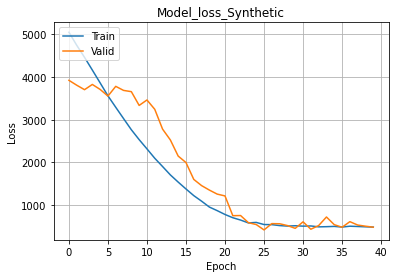

In [20]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history_synthetic.history['loss'])
plt.plot(history_synthetic.history['val_loss'])
plt.title('Model_loss_Synthetic')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.grid(True)
# plt.xticks(np.arange(1, 100, 5))
plt.show()


In [25]:
# Ta injaaa
print(training_touch.shape)
training_touch = training_touch[0:2000]
training_touch.shape

(2000, 250, 6)


(2000, 250, 6)

In [32]:
import copy

old_list = [[1, 1, 1], [2, 2, 2], [3, 3, 3]]
new_list = copy.deepcopy(old_list)

print("Old list:", old_list)
print("New list:", new_list)

Old list: [[1, 1, 1], [2, 2, 2], [3, 3, 3]]
New list: [[1, 1, 1], [2, 2, 2], [3, 3, 3]]


In [35]:
import copy

auto_2 = copy.copy(auto_1)# get the weights from first training

In [37]:
# train autoencoder on hand-collected touch data
history_training = auto_2.fit(training_touch, training_touch,
         epochs=40, # nana 10 
         batch_size=32,
         shuffle=True,
         validation_split=0.2);

Train on 1600 samples, validate on 400 samples
Epoch 1/40
1600/1600 [==============================] - 16s 10ms/sample - loss: 79.5008 - val_loss: 143.1364
Epoch 2/40
1600/1600 [==============================] - 16s 10ms/sample - loss: 78.0291 - val_loss: 159.8203
Epoch 3/40
1600/1600 [==============================] - 16s 10ms/sample - loss: 78.8149 - val_loss: 119.4045
Epoch 4/40
1600/1600 [==============================] - 16s 10ms/sample - loss: 77.2556 - val_loss: 173.9975
Epoch 5/40
1600/1600 [==============================] - 16s 10ms/sample - loss: 77.9146 - val_loss: 135.8340
Epoch 6/40
1600/1600 [==============================] - 16s 10ms/sample - loss: 77.7578 - val_loss: 185.6431
Epoch 7/40
1600/1600 [==============================] - 16s 10ms/sample - loss: 77.1007 - val_loss: 149.9141
Epoch 8/40
1600/1600 [==============================] - 16s 10ms/sample - loss: 77.3153 - val_loss: 177.9711
Epoch 9/40
1600/1600 [==============================] - 16s 10ms/sample - loss: 7

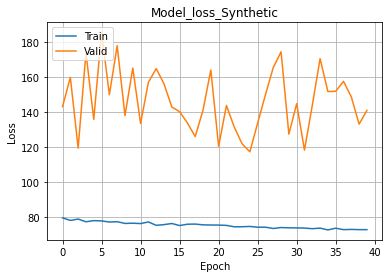

In [38]:
import matplotlib.pyplot as plt 
# Plot training & validation loss values
plt.plot(history_training.history['loss'])
plt.plot(history_training.history['val_loss'])
plt.title('Model_loss_Synthetic')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.grid(True)
# plt.xticks(np.arange(1, 100, 5))
plt.show()


### 18 May 2021 Ta Inja

In [36]:
auto.save('final_stage1')

In [4]:
# history_synthetic.history


In [41]:
auto_1.get_weights()

[array([[[ 0.02846218,  0.08404931,  0.06217669, ..., -0.02042348,
           0.08275124,  0.08786616],
         [-0.00181436,  0.08537602,  0.05922807, ...,  0.01315276,
          -0.01754376, -0.08749555],
         [-0.06452453, -0.01652521, -0.10819091, ...,  0.08614668,
          -0.10867064, -0.05181026],
         [ 0.04062252,  0.04904445, -0.0255137 , ..., -0.04417444,
           0.06216457,  0.07243618],
         [-0.10004892,  0.12677886,  0.03357613, ..., -0.03293255,
           0.00492595, -0.10630114],
         [-0.04128124,  0.0577057 , -0.08120963, ..., -0.07296392,
          -0.01146874,  0.09606436]],
 
        [[ 0.03900577, -0.01512695, -0.01038423, ..., -0.0212494 ,
          -0.03677199, -0.07529829],
         [-0.00572775,  0.04911309, -0.0568616 , ...,  0.05305397,
          -0.05564831, -0.03432116],
         [ 0.02688415,  0.00284382,  0.05368807, ...,  0.22737005,
           0.00127609,  0.10828596],
         [ 0.01938057, -0.00975343, -0.07005184, ...,  0.0547

In [42]:
auto_2.get_weights()

[array([[[ 0.02846218,  0.08404931,  0.06217669, ..., -0.02042348,
           0.08275124,  0.08786616],
         [-0.00181436,  0.08537602,  0.05922807, ...,  0.01315276,
          -0.01754376, -0.08749555],
         [-0.06452453, -0.01652521, -0.10819091, ...,  0.08614668,
          -0.10867064, -0.05181026],
         [ 0.04062252,  0.04904445, -0.0255137 , ..., -0.04417444,
           0.06216457,  0.07243618],
         [-0.10004892,  0.12677886,  0.03357613, ..., -0.03293255,
           0.00492595, -0.10630114],
         [-0.04128124,  0.0577057 , -0.08120963, ..., -0.07296392,
          -0.01146874,  0.09606436]],
 
        [[ 0.03900577, -0.01512695, -0.01038423, ..., -0.0212494 ,
          -0.03677199, -0.07529829],
         [-0.00572775,  0.04911309, -0.0568616 , ...,  0.05305397,
          -0.05564831, -0.03432116],
         [ 0.02688415,  0.00284382,  0.05368807, ...,  0.22737005,
           0.00127609,  0.10828596],
         [ 0.01938057, -0.00975343, -0.07005184, ...,  0.0547

In [ ]:
# Try shuffle data befor feeding to the model

In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t, t, test_size=0.2)

# train autoencoder on hand-collected touch data (DONE)

In [40]:
training_touch = training_touch[0:1000]

In [41]:
training_touch.shape

(1000, 250, 6)

In [42]:
# train autoencoder on hand-collected touch data
history_training = auto.fit(training_touch, training_touch,
         epochs=40, # nana 10 
         batch_size=16,
         shuffle=True,
         validation_split=0.2);

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 12s 16ms/sample - loss: 1439.2646 - val_loss: 1127.3429
Epoch 2/20
800/800 [==============================] - 12s 15ms/sample - loss: 1002.4262 - val_loss: 1230.8165
Epoch 3/20
800/800 [==============================] - 13s 17ms/sample - loss: 727.9819 - val_loss: 1034.4965
Epoch 4/20
800/800 [==============================] - 12s 15ms/sample - loss: 521.7486 - val_loss: 914.2121
Epoch 5/20
800/800 [==============================] - 12s 15ms/sample - loss: 376.1349 - val_loss: 1005.3056
Epoch 6/20
800/800 [==============================] - 12s 15ms/sample - loss: 282.3268 - val_loss: 748.1751
Epoch 7/20
800/800 [==============================] - 12s 15ms/sample - loss: 231.1402 - val_loss: 709.7206
Epoch 8/20
800/800 [==============================] - 12s 15ms/sample - loss: 203.5439 - val_loss: 694.3421
Epoch 9/20
800/800 [==============================] - 12s 15ms/sample - loss: 187.54

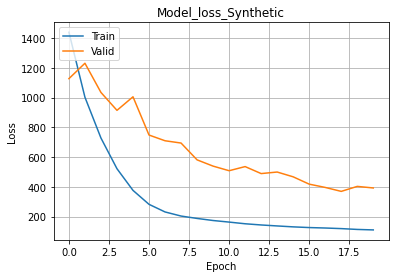

In [43]:
import matplotlib.pyplot as plt 
# Plot training & validation loss values
plt.plot(history_training.history['loss'])
plt.plot(history_training.history['val_loss'])
plt.title('Model_loss_Synthetic')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.grid(True)
# plt.xticks(np.arange(1, 100, 5))
plt.show()


# Define a method of saving the encoder to a file (auto.save(<path>))

In [31]:

embedded_model = load_model('stage_1_model.h5')  # loads weights in model
embedding = embedded_model.predict(total_touch, verbose=1)  # runs encoder on all human collected data
print(embedding.shape) 

/opt/anaconda3/envs/mlpet/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


119337/119337 [==============================] - 867s 7ms/step
(119337, 256)


In [11]:
# defines second stage model
input_touch = layers.Input((256,))
x = layers.Dense(128)(input_touch)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(feature_num, activation='relu')(x)

model = Model(input_touch, x)
model.compile(optimizer='RMSprop', loss='mse', metrics=['acc'])
model.summary()

NameError: name 'feature_num' is not defined

In [ ]:
# generator for feeding GPU stage 2 training data in batches (each call generates one batch)
# seems a bit odd even to Zeping - since the stage 1 problem is bigger
def gen(batch_size, arr):
    i = 0
    while True:
        temp_arr = arr[i * batch_size:(i + 1) * batch_size]
        length = len(temp_arr)
        temp_embedding = zeros((length, 256))
        temp_feature = zeros((length, feature_num))
        for j in range(length):
            temp_num = temp_arr[j]
            temp_embedding[j] = embedding[temp_num]
            temp_feature[j] = total_features[total_type[temp_num]]
        i += 1
        if i * batch_size >= len(arr):
            i = 0
        yield temp_embedding, temp_feature
        
batch_size = 128
this_arr = arange(total_length)
random.shuffle(this_arr)

# split data into training, validation, and test sets
# NEED to ADD a random seed to drive the split

split = total_length // 10 
validation_arr = this_arr[8 * split:9 * split]  # indices of validation data
test_arr = this_arr[9 * split:]
train_arr = this_arr[:8 * split]

history = model.fit_generator(gen(batch_size, train_arr),
                              steps_per_epoch=int(len(train_arr) / batch_size) + 1,
                              epochs=100,  # use as many as possible, given that overfitting reduced by 
                              # dropout layers
                              validation_data=gen(batch_size, validation_arr),
                              validation_steps=int(len(validation_arr) / batch_size) + 1,
                              )

Epoch 1/100
746/746 [==============================] - 40s 54ms/step - loss: 140.1295 - acc: 0.4686 - val_loss: 106.9047 - val_acc: 0.5437
Epoch 2/100
746/746 [==============================] - 34s 46ms/step - loss: 113.1769 - acc: 0.5544 - val_loss: 98.6187 - val_acc: 0.5832
Epoch 3/100
746/746 [==============================] - 126s 170ms/step - loss: 105.2333 - acc: 0.5852 - val_loss: 91.8124 - val_acc: 0.6014
Epoch 4/100
746/746 [==============================] - 39s 52ms/step - loss: 99.0104 - acc: 0.6057 - val_loss: 93.0033 - val_acc: 0.6035
Epoch 5/100
746/746 [==============================] - 40s 54ms/step - loss: 94.1189 - acc: 0.6233 - val_loss: 84.0081 - val_acc: 0.6437
Epoch 6/100
746/746 [==============================] - 41s 56ms/step - loss: 90.2463 - acc: 0.6345 - val_loss: 81.8561 - val_acc: 0.6340
Epoch 7/100
746/746 [==============================] - 37s 50ms/step - loss: 86.7497 - acc: 0.6458 - val_loss: 88.6752 - val_acc: 0.5832
Epoch 8/100
746/746 [==============

In [ ]:
model = load_model('stage_2_model.h5')
# model = load_model('stage_2_model.h5')

In [ ]:
# tests stage 2 performance
test_data = []
# with open('ExperimentSmall/test.txt', 'r') as f:
with open('Experiment/test.txt', 'r') as f:

    for _, line in enumerate(f):
        test_data.append(line.split()[0].split(','))
        
test_data = array(test_data[-250:])
plot(test_data);  # plots tail end of user data

pred_embedding = embedded_model.predict(expand_dims(test_data, axis=0))  # run the first stage
pred = model.predict(pred_embedding)[0]  # run the stage 2 model
chosen_index = min(range(csv_len),
                   key=lambda i: linalg.norm(features[i] - pred))  # find index of closet lyric
print(liwc_csv.iloc[chosen_index]['C'])
print()

for i, value in enumerate(liwc_csv.columns.values[8:]):
    print(value, liwc_csv.iloc[chosen_index][value], pred[i])
    # chosen lyric feature value, user touch feature value

# Clustering 

In [ ]:
est = KMeans(n_clusters=11)
est.fit(embedding)
labels = est.labels_

In [ ]:
indice = []
for i, t in enumerate(labels):
    if t == 0:
        indice.append(i)
        
a = list(indice)
for i in range(len(a)):
    print(total_type[a[i]], end=' ')

# LSTM Testing

In [24]:
input_touch = layers.Input((250, 6))
x = layers.LSTM(200, return_sequences=True, recurrent_dropout=0.2)(input_touch)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(200, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(feature_num, activation='relu')(x)

model = Model(input_touch, x)
model.compile(optimizer='RMSprop', loss='mse', metrics=['acc'])
model.summary()

NameError: name 'feature_num' is not defined

In [ ]:
def gen(batch_size, arr):
    i = 0
    while True:
        temp_arr = arr[i * batch_size:(i + 1) * batch_size]
        length = len(temp_arr)
        temp_touch = zeros((length, 250, 6))
        temp_type = zeros((length, feature_num))
        for j in range(length):
            temp_num = temp_arr[j]
            temp_touch[j] = total_touch[temp_num]
            temp_type[j] = total_features[total_type[temp_num]]
        i += 1
        if i * batch_size >= len(arr):
            i = 0
        yield temp_touch, temp_type
        
batch_size = 128
this_arr = arange(total_length)
random.shuffle(this_arr)
split = total_length // 10
validation_arr = this_arr[8 * split:9 * split]
test_arr = this_arr[9 * split:]
train_arr = this_arr[:8 * split]

# https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/
history = model.fit_generator(gen(batch_size, train_arr),
                              steps_per_epoch=int(len(train_arr) / batch_size) + 1,
                              epochs=50,
                              validation_data=gen(batch_size, validation_arr),
                              validation_steps=int(len(validation_arr) / batch_size) + 1,
                              )

In [ ]:
#LSTM 30
plot(history.history['loss'], label='loss')
plot(history.history['val_loss'], label='val_loss')
legend()
show()

figure()
plot(history.history['acc'], label='acc')
plot(history.history['val_acc'], label='val_acc')
legend()
show()

In [ ]:
test_data = []
with open('../../Touch Into Text/Experiment/test.txt', 'r') as f:
# with open('../../Touch Into Text/ExperimentSmall/test.txt', 'r') as f:

    for _, line in enumerate(f):
        test_data.append(line.split()[0].split(','))
        
test_data = array(test_data[-300:-50])
plot(test_data);

pred = model.predict(expand_dims(test_data, axis=0))[0]
chosen_index = min(range(csv_len),
                   key=lambda i: linalg.norm(features[i] - pred))
print(liwc_csv.iloc[chosen_index]['C'])

In [ ]:
test = test_arr[3]
temp_touch = total_touch[test:test+1]
plot(temp_touch[0]);
print(text[total_type[test]])
print()

pred = model.predict(temp_touch)[0]
chosen_index = min(range(csv_len),
                   key=lambda i: linalg.norm(features[i] - pred))
print(liwc_csv.iloc[chosen_index]['C'])

# Nana Scratch

In [18]:
num = [1, 2, 3, 4]
sq = []

In [19]:
for i in num:
    sq.append(i**2)
    
print(sq)

[1, 4, 9, 16]


In [ ]:
sq = map(num, sq)

In [23]:
def squared(num):
    return num**2

sq = map(squared, num)

In [26]:
list(sq)

[1, 4, 9, 16]

In [27]:
str_nums = ["4", "8", "6", "5", "3", "2", "8", "9", "2", "5"]

In [31]:
type(str_nums[0])

str

In [34]:
numbers = [1, 2, 3, 4, 5]
sq = map(lambda num: num**2, numbers)

In [38]:
numbers = [1, 2, 3, 4, 5]
squared = map(lambda num: num ** 2, numbers)

In [39]:
lambda num: num ** 2

<function __main__.<lambda>(num)>

In [40]:
first_it = [1, 2, 3]
second_it = [4, 5, 6, 7]

In [42]:
list(map(pow, first_it, second_it))

[1, 32, 729]